In [19]:
"""
Notebook 2: CPU-Friendly Model Training & Evaluation (Multi-Router)
Purpose:
  - Load all 10 individual hourly_router_processed_with_anomalies.parquet files.
  - Iterate through each router's data within the combined DataFrame.
  - For each router:
    - Perform time series splitting (train/val/test).
    - Apply data scaling.
    - Run GRU-LSTM, SARIMA, NBEATS, and TiDE experiments.
    - Evaluate performance using MAE, RMSE, sMAPE, MSLE, and P99 Absolute Error.
    - Save test set predictions (y_true, y_pred) for later visualization.
    - Accumulate all results (metrics, times) into a single master list.
  - Consolidate and save all results to 'all_model_results.csv'.
Inputs:
  - outputs/ch4/hourly_<router>_processed_with_anomalies.parquet (10 files from Notebook 1)
Outputs:
  - outputs/ch4/all_model_results.csv
  - outputs/ch4/predictions/*.parquet (test set predictions for each experiment)
"""

#######################################################################
# 0. Environment set‑up                                               #
#######################################################################
# ☑️  Install all dependencies.
# !pip install --quiet pandas pyarrow matplotlib seaborn numpy scikit-learn tqdm torch statsmodels neuralforecast pytorch-lightning

import os
import warnings
import random
import gc
import itertools
import time
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# For tree-boosting baseline
from xgboost import XGBRegressor           # ✓ uses the scikit-learn API  [oai_citation:0‡mljar.com](https://mljar.com/blog/xgboost-early-stopping/?utm_source=chatgpt.com)

# For Data Scaling
from sklearn.preprocessing import StandardScaler
# For Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

# PyTorch specific imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# For EarlyStopping in PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping # Ensure this is imported

# For SARIMA (from statsmodels)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For NeuralForecast models
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, TiDE

# Suppress minor warnings for cleaner output in Jupyter
warnings.filterwarnings("ignore")

# Ensure plots appear inline in Jupyter Notebook
%matplotlib inline

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150 # Increase resolution for better quality plots
plt.rcParams['savefig.dpi'] = 300 # Save plots with higher resolution

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Check for GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#######################################################################
# 1. Configuration                                                    #
#######################################################################

# --- Paths & File Names ---
# Input: Directory containing your INDIVIDUAL processed hourly Parquet files (from Notebook 1)
INPUT_PROCESSED_HOURLY_DIR = Path("outputs/ch4") # This directory contains hourly_<router>_processed_with_anomalies.parquet files

# Output root directory for results (figures, metrics, models)
OUT_DIR           = Path("outputs/ch4").absolute(); OUT_DIR.mkdir(parents=True, exist_ok=True)
PREDICTIONS_DIR = OUT_DIR / "predictions"; PREDICTIONS_DIR.mkdir(exist_ok=True, parents=True)


# ─── loss tracking ---------------------------------------------------
LOSS_LOG         = {}         # maps variant_key → list[float]
SELECTED_ROUTER  = "jacksonville"   # router you care about
FIRST_PASS_DONE  = set()      # so we only dump each family once
LOSS_FILE        = OUT_DIR / "prev_results/settings_2/loss_histories.pkl.gz"
# --------------------------------------------------------------------

# --- Data Specifics ---
TARGET_COL        = "in_packets"           # The volume metric (packets)
ROUTER_COL        = "router"               # Column for router name

# --- Anomaly Detection Parameters (just names for columns, values from Notebook 1) ---
ANOM_SCORE_COL    = "if_score"             
ANOM_FLAG_COL     = "if_flag"              

# --- Time Series Parameters ---
LOOKBACK          = 48                     # Sliding window length (hours)
HORIZONS          = [1, 6, 12, 24]         # Prediction horizons
TEST_SIZE_HOURS   = 7 * 24                 # 7 days for testing
VAL_SIZE_HOURS    = 7 * 24                 # 7 days for validation

# --- Model Training Parameters ---
BATCH_SIZE        = 128
EPOCHS            = 50                     # Reduced epochs for quick validation as requested
EARLY_STOP_PATIENCE = 10                # Patience for early stopping
LEARNING_RATE     = 1e-3

# --- NeuralForecast specific parameters ---
NF_LOOKBACK_SIZE = LOOKBACK 
NF_MODEL_MAX_HORIZON = max(HORIZONS) 
FREQ              = "h"    

print(f"Configuration loaded.")
print(f"Input processed hourly data from: {INPUT_PROCESSED_HOURLY_DIR}")
print(f"Outputs will be saved to: {OUT_DIR} (predictions: {PREDICTIONS_DIR})")
print(f"Time series lookback: {LOOKBACK} hours, horizons: {HORIZONS}")
print(f"Training Epochs (Validation Run): {EPOCHS}, Early Stop Patience: {EARLY_STOP_PATIENCE}")
print(f"Using device: {DEVICE}")

#######################################################################
# 2. Data Splitting, Scaling, and Windowing                           #
#######################################################################

def build_windows(df: pd.DataFrame, target_col: str, feature_cols: List[str],
                  lookback: int, horizons: List[int], mask_out: bool,
                  anom_flag_col: Optional[str] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Builds sliding windows (X, y) from the time series data.
    Returns X, y, and the timestamps corresponding to the y values.
    """
    data = df.copy()
    if mask_out:
        if anom_flag_col is None or anom_flag_col not in data.columns:
            raise ValueError(f"'{anom_flag_col}' must be present in DataFrame if 'mask_out' is True.")
        initial_rows = len(data)
        data = data[data[anom_flag_col] == 0].copy()
        print(f"  Masked out {initial_rows - len(data)} anomalous periods.")
    
    if len(data) < lookback + max(horizons):
        print(f"  Warning: Not enough data ({len(data)} points) for windowing after masking. Returning empty arrays.")
        return np.array([]).reshape(0, lookback, len(feature_cols)), \
               np.array([]).reshape(0, len(horizons)), \
               np.array([])

    data_features = data[feature_cols].values.astype(np.float32)
    data_target = data[target_col].values.astype(np.float32)
    data_timestamps = data.index.to_numpy() # Get numpy array of timestamps

    X_list, y_list, y_timestamps_list = [], [], []
    for i in range(lookback, len(data) - max(horizons) + 1):
        input_window = data_features[i - lookback:i]
        targets_for_window = [data_target[i + h - 1] for h in horizons]
        
        # The timestamp for y[0] (the first prediction horizon) is data_timestamps[i].
        y_timestamps_list.append(data_timestamps[i])

        X_list.append(input_window)
        y_list.append(targets_for_window)

    if not X_list:
        print(f"  No windows could be built after processing. Returning empty arrays.")
        return np.array([]).reshape(0, lookback, len(feature_cols)), \
               np.array([]).reshape(0, len(horizons)), \
               np.array([])

    X = np.stack(X_list)
    y = np.array(y_list).astype(np.float32)
    y_timestamps = np.array(y_timestamps_list)
    print(f"  Generated {X.shape[0]} windows. X shape: {X.shape}, y shape: {y.shape}")
    return X, y, y_timestamps


#######################################################################
# 3. Model Definitions                                                #
#######################################################################

class GRULSTM(nn.Module):
    def __init__(self, input_features: int, hidden_dim: int = 128, output_horizon: int = 1):
        super().__init__()
        self.gru = nn.GRU(input_features, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_horizon)

    def forward(self, x):
        out, _ = self.gru(x)
        out, _ = self.lstm(out)
        return self.fc(out[:, -1, :])


#######################################################################
# 4. Training and Prediction Functions                                #
#######################################################################

def train_torch_model(model: nn.Module, X_train: np.ndarray, y_train: np.ndarray,
                      epochs: int, batch_size: int, learning_rate: float,
                      X_val: Optional[np.ndarray] = None, y_val: Optional[np.ndarray] = None) -> Tuple[nn.Module, float]:
    """
    Trains a PyTorch model with EarlyStopping and returns trained model and training duration.
    """
    if X_train.size == 0 or y_train.size == 0:
        print("  Training data is empty. Skipping training.")
        return model, 0.0

    print(f"  Training PyTorch model for {epochs} epochs on device: {DEVICE}...")
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    has_validation = X_val is not None and y_val is not None and X_val.size > 0 and y_val.size > 0
    if has_validation:
        val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()
    epochs_no_improve = 0

    start_time = time.time()
    epoch_losses = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        epoch_losses.append(float(avg_train_loss))
        
        current_val_loss = float('inf')
        if has_validation:
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for X_batch_val, y_batch_val in val_loader:
                    X_batch_val, y_batch_val = X_batch_val.to(DEVICE), y_batch_val.to(DEVICE)
                    outputs_val = model(X_batch_val)
                    loss_val = criterion(outputs_val, y_batch_val)
                    total_val_loss += loss_val.item()
            avg_val_loss = total_val_loss / len(val_loader)
            current_val_loss = avg_val_loss
            print(f"  Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        else:
            current_val_loss = avg_train_loss # Use train loss for early stopping if no val set
            print(f"  Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        # Early Stopping Logic
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_model_state = model.state_dict() # Save best model state
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print(f"  Early stopping triggered at epoch {epoch+1} (no improvement for {EARLY_STOP_PATIENCE} epochs).")
                break # Exit training loop

    end_time = time.time()
    training_duration = end_time - start_time
    print(f"  Training complete. Duration: {training_duration:.2f} seconds.")

    # Load the best model state before returning
    model.load_state_dict(best_model_state)
    return model, training_duration, epoch_losses   # 3 values now

def get_predictions_and_time(model: nn.Module, X_test: np.ndarray, batch_size: int) -> Tuple[np.ndarray, float]:
    """
    Generates predictions from a PyTorch model and returns predictions and inference duration.
    """
    if X_test.size == 0:
        output_horizon_dim = model.fc.out_features if hasattr(model, 'fc') else len(HORIZONS)
        return np.array([]).reshape(0, output_horizon_dim), 0.0

    model.eval() # Set model to evaluation mode
    test_dataset = TensorDataset(torch.from_numpy(X_test).float())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    predictions = []
    start_time = time.time()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch[0].to(DEVICE)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
    inference_duration = time.time() - start_time

    if not predictions: 
        output_horizon_dim = model.fc.out_features if hasattr(model, 'fc') else len(HORIZONS)
        return np.array([]).reshape(0, output_horizon_dim), inference_duration

    return np.concatenate(predictions, axis=0), inference_duration


#######################################################################
# 5. Evaluation Metrics (Expanded)                                    #
#######################################################################

def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calculates MAE, RMSE, sMAPE, MSLE, and P99 Absolute Error.
    """
    y_true_safe = np.maximum(y_true, 0) # Ensure non-negative for log/percentage metrics
    y_pred_safe = np.maximum(y_pred, 0)
    
    mae = mean_absolute_error(y_true_safe, y_pred_safe)
    rmse = np.sqrt(mean_squared_error(y_true_safe, y_pred_safe))
    
    # sMAPE: Symmetric Mean Absolute Percentage Error
    smape_denominator = (np.abs(y_true_safe) + np.abs(y_pred_safe))
    if np.sum(smape_denominator) == 0:
        smape = 0.0
    else:
        smape = np.mean(2 * np.abs(y_pred_safe - y_true_safe) / (smape_denominator + 1e-8)) * 100
    
    # MSLE: Mean Squared Logarithmic Error
    if np.all(y_true_safe == 0) and np.all(y_pred_safe == 0):
        msle = 0.0 # If both are consistently zero, error is zero
    else:
        # Add epsilon before log to prevent log(0)
        msle = mean_squared_log_error(y_true_safe + 1e-8, y_pred_safe + 1e-8) 
    
    # P99 Absolute Error
    p99_abs_error = np.percentile(np.abs(y_true_safe - y_pred_safe), 99)
    
    return {
        "MAE": mae,
        "RMSE": rmse,
        "sMAPE": smape,
        "MSLE": msle,
        "P99_abs_error": p99_abs_error
    }


#######################################################################
# 6. Model Experiment Runners                                         #
#######################################################################

def run_sarima_standalone_experiment(train_df: pd.DataFrame, test_df: pd.DataFrame, target_scaler: StandardScaler,
                                    router_label: str, horizons: List[int], all_results: List[Dict], freq_param: str):
    """
    Runs a standalone SARIMA experiment using statsmodels library.
    Evaluates by forecasting from the end of training data for each horizon.
    """
    print(f"\n--- Running Standalone SARIMA Experiment: SARIMA_raw ---")
    
    train_series_scaled = train_df[TARGET_COL + '_scaled']
    test_series_scaled = test_df[TARGET_COL + '_scaled']

    # Ensure train_series is not empty for SARIMA fitting
    if train_series_scaled.empty:
        print(f"  Warning: Training series for SARIMA is empty for {router_label}. Skipping.")
        return

    print(f"  Fitting SARIMA model on scaled training data (length: {len(train_series_scaled)})...")
    start_time = time.time()
    try:
        model = SARIMAX(train_series_scaled, order=(1,1,1), seasonal_order=(1,1,1,24),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False) 
        print("  SARIMA model fitted successfully.")
    except Exception as e:
        print(f"  Error fitting SARIMA: {e}. Skipping SARIMA experiment for this router.")
        return
    train_duration = time.time() - start_time

    # Ensure test_series is not empty for forecasting
    if test_series_scaled.empty:
        print(f"  Warning: Test series for SARIMA is empty for {router_label}. Skipping forecast and evaluation.")
        return
    
    forecast_steps = len(test_series_scaled) + max(horizons) - 1
    
    start_time = time.time()
    try:
        forecast_obj = model_fit.get_forecast(steps=forecast_steps)
        predictions_scaled_full = forecast_obj.predicted_mean.values
        print(f"  Generated {len(predictions_scaled_full)} forecast steps.")
    except Exception as e:
        print(f"  Error generating SARIMA forecasts: {e}. Skipping evaluation.")
        return
    inference_duration = time.time() - start_time

    for horizon in horizons:
        # Dummy call to build_windows to get the correct `y_true` shape and values for this horizon
        _, y_test_true_h_original_full_structure, y_test_timestamps = build_windows( # Get timestamps
            test_df, TARGET_COL, [TARGET_COL], # Only target for true values
            LOOKBACK, horizons, False, ANOM_FLAG_COL # No masking
        )
        y_true_h_original = y_test_true_h_original_full_structure[:, horizons.index(horizon)]
        
        # Initialize y_pred_original_h and m
        sarima_y_pred_h_original = np.array([])
        m = {"MAE": np.nan, "RMSE": np.nan, "sMAPE": np.nan, "MSLE": np.nan, "P99_abs_error": np.nan}


        # Ensure predictions_scaled_full has enough data for this horizon
        if len(predictions_scaled_full) < (horizon - 1) + len(y_true_h_original):
            print(f"  Warning: SARIMA full prediction array too short for H{horizon}. Expected at least {len(y_true_h_original)} more points, got {len(predictions_scaled_full) - (horizon - 1)}. Setting metrics to NaN.")
        else:
            sarima_y_pred_h_scaled = predictions_scaled_full[
                (horizon - 1) : (horizon - 1) + len(y_true_h_original)
            ]
            
            if len(sarima_y_pred_h_scaled) != len(y_true_h_original):
                print(f"  Warning: SARIMA predictions length mismatch for H{horizon}. Expected {len(y_true_h_original)}, got {len(sarima_y_pred_h_scaled)}. Setting metrics to NaN.")
            else:
                sarima_y_pred_h_original = target_scaler.inverse_transform(sarima_y_pred_h_scaled.reshape(-1, 1)).flatten()
                m = calculate_metrics(y_true_h_original, sarima_y_pred_h_original)

        # Save predictions for this horizon
        if not y_test_timestamps.size == 0 and not y_true_h_original.size == 0 and not sarima_y_pred_h_original.size == 0:
            predictions_df = pd.DataFrame({
                'ds': y_test_timestamps, # Timestamps for the test windows
                'y_true': y_true_h_original,
                'y_pred': sarima_y_pred_h_original
            })
            predictions_path = PREDICTIONS_DIR / f"SARIMA_SARIMA_raw_H{horizon}_predictions_{router_label}.parquet"
            predictions_df.to_parquet(predictions_path, index=False)
            print(f"      Saved predictions for SARIMA_raw H{horizon} to {predictions_path.name}")
        else:
            print(f"      Skipping saving predictions for SARIMA_raw H{horizon} due to empty data.")


        print(f"  SARIMA Horizon {horizon}h Metrics: MAE={m['MAE']:.2f}, RMSE={m['RMSE']:.2f}, sMAPE={m['sMAPE']:.2f}%, MSLE={m['MSLE']:.4f}, P99_abs_error={m['P99_abs_error']:.2f}")
        
        result_row = {
            "model": "SARIMA",
            "experiment": "SARIMA_raw",
            "horizon": horizon,
            "router": router_label,
            "train_time_sec": train_duration,
            "inference_time_sec": inference_duration,
            **m
        }
        all_results.append(result_row)
    
    del model, model_fit, predictions_scaled_full
    gc.collect()

    
# ----------------------------------------------------------------------
def run_xgboost_experiment(train_df: pd.DataFrame,
                           test_df:  pd.DataFrame,
                           target_scaler: StandardScaler,
                           router_label: str,
                           horizons: List[int],
                           all_results: List[Dict]):
    """
    Trains one XGBRegressor per forecast horizon and stores
    parquet predictions + metrics (same pattern as other models).
    """
    print("\n--- Running XGBoost Experiments --------------------------")
    feature_cols = [TARGET_COL + '_scaled', ANOM_SCORE_COL + '_scaled']  # wide but cheap

    # ---------------- build windows (masking NEVER used here) ----------
    X_train, y_train, _ = build_windows(
        train_df, TARGET_COL + '_scaled', feature_cols,
        LOOKBACK, horizons, mask_out=False
    )
    X_test,  y_test,  y_test_ts = build_windows(
        test_df,  TARGET_COL + '_scaled', feature_cols,
        LOOKBACK, horizons, mask_out=False
    )
    if X_train.size == 0 or X_test.size == 0:
        print("  Skipping XGBoost – not enough data.")
        return

    # ---- flatten the 3-D window => 2-D matrix the booster expects ----
    n_train = X_train.shape[0]
    n_test  = X_test.shape[0]
    X_train_2d = X_train.reshape(n_train, -1)
    X_test_2d  = X_test.reshape(n_test,  -1)

    # -------------------- train one model per horizon ------------------
    for h_idx, horizon in enumerate(horizons):
        y_train_h = y_train[:, h_idx]
        y_test_h  = y_test[:,  h_idx]                     # still scaled

        # strong default hyper-params for tabular volumes  [oai_citation:3‡xgboost.readthedocs.io](https://xgboost.readthedocs.io/en/latest/python/python_api.html?utm_source=chatgpt.com) [oai_citation:4‡swan-gallery.web.cern.ch](https://swan-gallery.web.cern.ch/notebooks/GPU_and_data/DeepLearning-GPU/XGBoost_with_Pandas_Parquet.html?utm_source=chatgpt.com)
        
        xgb = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=SEED,
            n_jobs=-1,
            eval_metric='rmse'
        )

        fit_kwargs = dict(
            X=X_train_2d,
            y=y_train_h,
            eval_set=[(X_test_2d, y_test_h)],
            verbose=False
        )

        # ----------------- XGBoost fitting -----------------
        t0 = time.time()

        try:
            # Preferred call – includes early-stopping if the local wheel supports it
            xgb.fit(
                X_train_2d, y_train_h,
                eval_set=[(X_test_2d, y_test_h)],
                early_stopping_rounds=50,      # <-- safe to keep
                verbose=False
            )
        except TypeError:
            # Fallback for stripped-down builds that reject early_stopping_rounds
            xgb.fit(
                X_train_2d, y_train_h,
                eval_set=[(X_test_2d, y_test_h)],
                verbose=False
            )

        train_time = time.time() - t0
        # ---------------------------------------------------
        
        # --------------------------- inference --------------------------
        t0 = time.time()
        y_pred_h_scaled = xgb.predict(X_test_2d)
        inf_time = time.time() - t0

        # inverse-scale --------------------------------------------------
        y_true_orig = target_scaler.inverse_transform(y_test_h.reshape(-1, 1)).flatten()
        y_pred_orig = target_scaler.inverse_transform(y_pred_h_scaled.reshape(-1, 1)).flatten()

        # ----------------------- metrics + parquet ----------------------
        m = calculate_metrics(y_true_orig, y_pred_orig)
        preds_df = pd.DataFrame({
            'ds':     y_test_ts,          # timestamps align with LOOKBACK window start
            'y_true': y_true_orig,
            'y_pred': y_pred_orig
        })
        p_path = PREDICTIONS_DIR / f"XGB_XGB_raw_H{horizon}_predictions_{router_label}.parquet"
        preds_df.to_parquet(p_path, index=False)
        print(f"      ✓ Saved XGB H{horizon} predictions → {p_path.name}")

        # log row
        all_results.append({
            "model": "XGBoost",
            "experiment": "XGB_raw",
            "horizon": horizon,
            "router": router_label,
            "train_time_sec": train_time,
            "inference_time_sec": inf_time,
            **m
        })

        # free booster memory explicitly
        del xgb
        gc.collect()
# ----------------------------------------------------------------------



def run_nf_experiment(model_type: str, df_full_scaled: pd.DataFrame, train_df: pd.DataFrame,
                      test_df: pd.DataFrame, target_scaler: StandardScaler,
                      router_label: str, experiments_config: List[Dict], all_results: List[Dict], freq_param: str):
    """
    Runs NeuralForecast models (N-BEATS, TiDE) with anomaly integration strategies.
    `df_full_scaled` is the complete time series with scaled features, including anomalies.
    """
    print(f"\n--- Running NeuralForecast Model: {model_type} ---")

    # Get test timestamps from `build_windows` to match `y_true` lengths
    _, _, y_test_timestamps_nf = build_windows(
        test_df, TARGET_COL + '_scaled', [TARGET_COL + '_scaled'],
        LOOKBACK, HORIZONS, False, ANOM_FLAG_COL
    )

    for exp_config in experiments_config:
        exp_name = exp_config['name'].replace("NF", model_type)
        print(f"\n    --- Running NeuralForecast Experiment: {exp_name} ---")

        # --- Model specific exogenous variable support checks ---
        if model_type == "NBEATS" and (exp_config['use_score'] or exp_config['name'].endswith('_both')): 
            print(f"    WARNING: {model_type} does not support historical exogenous variables. Skipping experiment: {exp_name}")
            continue 

        # Prepare training DataFrame for NeuralForecast (handling masking)
        nf_train_df = train_df.copy() 
        if exp_config['mask_out']:
            initial_rows = len(nf_train_df)
            nf_train_df = nf_train_df[nf_train_df[ANOM_FLAG_COL] == 0].copy()
            print(f"    Masked out {initial_rows - len(nf_train_df)} anomalous periods for training.")
        
        # Prepare `nf_train_df` columns for NeuralForecast
        nf_train_df = nf_train_df.reset_index().rename(columns={nf_train_df.index.name: "ds", TARGET_COL + '_scaled': "y"})
        nf_train_df['unique_id'] = router_label
        
        exogenous_features = []
        # Only add exogenous features if use_score is True AND model_type supports them (TiDE)
        if exp_config['use_score'] and model_type == "TiDE": 
            exogenous_features.append(ANOM_SCORE_COL + '_scaled')
            
        nf_train_df = nf_train_df[['unique_id', 'ds', 'y'] + exogenous_features]

        # Check if training data is empty after masking or for other reasons
        if nf_train_df.empty:
            print(f"    Warning: Training data for {exp_name} is empty. Skipping training and evaluation.")
            continue

        # Define model instance based on model_type
        model_instance = None
        # Common trainer_kwargs for EarlyStopping for NeuralForecast models
        
        # --- Early-Stopping (works with or without val loader) ---
        nf_early_stop_cb = EarlyStopping(
            monitor="train_loss",
            patience=EARLY_STOP_PATIENCE,
            mode="min",
            check_on_train_epoch_end=True
        )
        nf_trainer_kwargs = {"callbacks": [nf_early_stop_cb]}  # <- keep the rest of the code identical
        
        # nf_trainer_kwargs = {
        #     "callbacks": [pl.callbacks.EarlyStopping(monitor="val_loss", patience=EARLY_STOP_PATIENCE, mode="min")]
        # }


        if model_type == "NBEATS":
            model_instance = NBEATS(h=NF_MODEL_MAX_HORIZON, 
                                    input_size=NF_LOOKBACK_SIZE,
                                    hist_exog_list=None, # Explicitly None as NBEATS does not support exog
                                    max_steps=EPOCHS, learning_rate=LEARNING_RATE, random_seed=SEED,
                                    scaler_type=None, callbacks=[nf_early_stop_cb]
                                   )
        elif model_type == "TiDE":
            model_instance = TiDE(h=NF_MODEL_MAX_HORIZON, 
                                  input_size=NF_LOOKBACK_SIZE,
                                  hist_exog_list=exogenous_features if exogenous_features else None, # TiDE supports exog
                                  max_steps=EPOCHS, learning_rate=LEARNING_RATE, random_seed=SEED,
                                  scaler_type=None, callbacks=[nf_early_stop_cb]
                                 )
        else:
            raise ValueError(f"Unsupported NeuralForecast model type: {model_type} in run_nf_experiment function.")

        nf_instance = NeuralForecast(models=[model_instance], freq=freq_param) 

        print(f"    Fitting {model_type}...")
        start_time = time.time()
        nf_instance.fit(df=nf_train_df)
        train_duration = time.time() - start_time
        print(f"    {model_type} fitted. Duration: {train_duration:.2f} seconds.")
        
        
        # ---- grab NeuralForecast train losses robustly ---------------------
        if   hasattr(model_instance, "loss_hist"):       # NF ≥ 1.7
            epoch_losses = list(model_instance.loss_hist)
        elif hasattr(model_instance, "loss_history"):    # NF ≤ 1.6
            epoch_losses = list(model_instance.loss_history)
        else:                                            # very old / custom build
            epoch_losses = []        # leave empty but still create the key
            print(f"    ⚠️  could not find train-loss history for {model_type}")
        variant_key = f"{model_type}_{exp_name}"
        if router_label == SELECTED_ROUTER:
            LOSS_LOG[variant_key] = epoch_losses
        # --------------------------------------------------------------------

        # Perform cross-validation to get predictions for the test set
        df_full_for_nf = df_full_scaled.reset_index().rename(columns={df_full_scaled.index.name: "ds", TARGET_COL + '_scaled': "y"})
        df_full_for_nf['unique_id'] = router_label
        
        for exog_col in exogenous_features:
            if exog_col not in df_full_for_nf.columns:
                 pass
        
        nf_df_cols_full = ['unique_id', 'ds', 'y'] + (exogenous_features if exogenous_features else [])
        df_full_for_nf = df_full_for_nf[nf_df_cols_full]

        start_time = time.time()
        nf_predictions_df = nf_instance.cross_validation(
            df=df_full_for_nf,
            val_size=VAL_SIZE_HOURS,
            test_size=TEST_SIZE_HOURS,
            n_windows=None # Explicitly set n_windows to None to avoid conflict with test_size
        )
        inference_duration = time.time() - start_time
        print(f"    {model_type} prediction done. Duration: {inference_duration:.2f} seconds.")

        # Re-create the 'horizon' column manually for NF_predictions_df
        if 'horizon' not in nf_predictions_df.columns:
            print("  'horizon' column not found in NF predictions. Recreating it.")
            nf_predictions_df['cutoff'] = pd.to_datetime(nf_predictions_df['cutoff'])
            nf_predictions_df['ds'] = pd.to_datetime(nf_predictions_df['ds'])
            nf_predictions_df['horizon'] = ((nf_predictions_df['ds'] - nf_predictions_df['cutoff']).dt.total_seconds() // 3600).astype(int)
            nf_predictions_df = nf_predictions_df[nf_predictions_df['horizon'] > 0].copy()
            print("  Horizon column recreated — sample values:", nf_predictions_df["horizon"].unique()[:10])


        # Evaluate and store results, and save predictions for later plotting
        for h_idx, horizon in enumerate(HORIZONS):
            nf_preds_for_horizon = nf_predictions_df[nf_predictions_df['horizon'] == horizon]
            
            # Initialize with empty arrays in case nf_preds_for_horizon is empty
            y_true_original_h = np.array([])
            y_pred_original_h = np.array([])
            m = {"MAE": np.nan, "RMSE": np.nan, "sMAPE": np.nan, "MSLE": np.nan, "P99_abs_error": np.nan}


            if nf_preds_for_horizon.empty:
                print(f"    No predictions available for Horizon {horizon}h after filtering. Setting metrics to NaN.")
            else:
                y_true_scaled_h = nf_preds_for_horizon['y'].values
                y_pred_scaled_h = nf_preds_for_horizon[model_type].values 
                
                y_true_original_h = target_scaler.inverse_transform(y_true_scaled_h.reshape(-1, 1)).flatten()
                y_pred_original_h = target_scaler.inverse_transform(y_pred_scaled_h.reshape(-1, 1)).flatten()
                
                m = calculate_metrics(y_true_original_h, y_pred_original_h)

            # # Save predictions for this horizon
            # if not y_test_timestamps_nf.size == 0 and not y_true_original_h.size == 0 and not y_pred_original_h.size == 0: 
            #     predictions_df = pd.DataFrame({
            #         'ds': y_test_timestamps_nf, # Use the NF-specific timestamps for test windows
            #         'y_true': y_true_original_h,
            #         'y_pred': y_pred_original_h
            #     })
            
            if y_pred_original_h.size and y_true_original_h.size:
            # `nf_preds_for_horizon['ds']` has exactly the right length
                predictions_df = pd.DataFrame({
                    'ds': nf_preds_for_horizon['ds'].values,
                    'y_true': y_true_original_h,
                    'y_pred': y_pred_original_h
            })
            
                predictions_path = PREDICTIONS_DIR / f"{model_type}_{exp_name}_H{horizon}_predictions_{router_label}.parquet"
                predictions_df.to_parquet(predictions_path, index=False)
                print(f"      Saved predictions for {exp_name} H{horizon} to {predictions_path.name}")
            else:
                # print(f"      Skipping saving predictions for {exp_name} H{horizon} due to empty data.")
                print(f"      Skipping saving predictions for {exp_name} H{horizon} due to empty or mis-aligned data.")

            print(f"    Horizon {horizon}h Metrics: MAE={m['MAE']:.2f}, RMSE={m['RMSE']:.2f}, sMAPE={m['sMAPE']:.2f}%, MSLE={m['MSLE']:.4f}, P99_abs_error={m['P99_abs_error']:.2f}")
            
            result_row = {
                "model": model_type,
                "experiment": exp_name,
                "horizon": horizon,
                "router": router_label,
                "train_time_sec": train_duration,
                "inference_time_sec": inference_duration,
                **m
            }
            all_results.append(result_row)
        
        del model_instance, nf_instance, nf_train_df, df_full_for_nf, nf_predictions_df
        gc.collect()


#######################################################################
# 7. Main Execution for Notebook 2                                    #
#######################################################################

def main():
    print("\n--- Initiating Notebook 2: CPU-Friendly Model Training & Evaluation (Multi-Router) ---")

    # 1. Load all individual processed hourly Parquet files
    print(f"\nLoading all processed hourly data from: {INPUT_PROCESSED_HOURLY_DIR}/*.parquet")
    all_processed_hourly_files = sorted(list(INPUT_PROCESSED_HOURLY_DIR.glob("hourly_*_processed_with_anomalies.parquet")))
    
    if not all_processed_hourly_files:
        print(f"Error: No processed hourly Parquet files found in {INPUT_PROCESSED_HOURLY_DIR}. Please run Notebook 1 first.")
        return

    # Load all into a single Pandas DataFrame (feasible as these are small files)
    list_df_hourly = []
    for file_path in tqdm(all_processed_hourly_files, desc="Loading hourly files"):
        try:
            df = pd.read_parquet(file_path)
            # Ensure router column is present and correct (it should be from Notebook 1)
            router_label_from_file = file_path.stem.replace('hourly_', '').replace('_processed_with_anomalies', '')
            if ROUTER_COL not in df.columns:
                df[ROUTER_COL] = router_label_from_file
            list_df_hourly.append(df)
        except Exception as e:
            print(f"Warning: Could not load {file_path.name}: {e}. Skipping this file.")
            continue
    
    if not list_df_hourly:
        print("No valid hourly processed data loaded. Exiting.")
        return

    df_combined_hourly = pd.concat(list_df_hourly, ignore_index=False) # Keep original index (timestamps)
    print(f"Loaded combined hourly data: {len(df_combined_hourly)} rows from {len(list_df_hourly)} routers.")
    del list_df_hourly # Free memory
    gc.collect()

    # Get unique routers for iteration
    unique_routers = df_combined_hourly[ROUTER_COL].unique().tolist()
    unique_routers.sort()
    print(f"Found {len(unique_routers)} unique routers: {unique_routers}")

    # Initialize master results list
    all_results = []

    # Iterate through each router for processing
    for router_idx, router_label in enumerate(tqdm(unique_routers, desc="Processing Routers for Modeling")):
        print(f"\n==== Starting Model Training & Evaluation for Router: {router_label} ({router_idx + 1}/{len(unique_routers)}) ====")
        
        # Filter data for current router
        df_hourly_processed_single_router = df_combined_hourly[df_combined_hourly[ROUTER_COL] == router_label].copy()
        
        if df_hourly_processed_single_router.empty:
            print(f"  Warning: No hourly data found for {router_label}. Skipping this router.")
            continue

        # Safeguard: Ensure no NaNs in critical columns (should be handled by Notebook 1, but for robustness)
        initial_rows = len(df_hourly_processed_single_router)
        df_hourly_processed_single_router.dropna(subset=[TARGET_COL, ANOM_SCORE_COL], inplace=True)
        if len(df_hourly_processed_single_router) < initial_rows:
            print(f"  Dropped {initial_rows - len(df_hourly_processed_single_router)} rows with NaNs in target/anomaly columns for {router_label}.")

        # Time Series Splitting
        print("\n  --- Splitting Data into Train/Validation/Test Sets ---")
        total_len = len(df_hourly_processed_single_router)
        
        min_data_required = TEST_SIZE_HOURS + VAL_SIZE_HOURS + LOOKBACK + max(HORIZONS)
        if total_len < min_data_required:
            print(f"  Warning: Not enough data for requested split sizes and lookback/horizons for {router_label}. Total: {total_len} hours. Needed at least: {min_data_required} hours. Skipping this router.")
            continue

        test_start_idx = total_len - TEST_SIZE_HOURS
        val_start_idx = test_start_idx - VAL_SIZE_HOURS

        train_df = df_hourly_processed_single_router.iloc[:val_start_idx].copy()
        val_df = df_hourly_processed_single_router.iloc[val_start_idx:test_start_idx].copy()
        test_df = df_hourly_processed_single_router.iloc[test_start_idx:].copy()

        print(f"  Train set size: {len(train_df)} hours (from {train_df.index.min()} to {train_df.index.max()})")
        print(f"  Validation set size: {len(val_df)} hours (from {val_df.index.min()} to {val_df.index.max()})")
        print(f"  Test set size: {len(test_df)} hours (from {test_df.index.min()} to {test_df.index.max()})")

        # Data Scaling
        print("\n  --- Scaling Time Series Data ---")
        target_scaler = StandardScaler()
        train_df[TARGET_COL + '_scaled'] = target_scaler.fit_transform(train_df[[TARGET_COL]])
        val_df[TARGET_COL + '_scaled'] = target_scaler.transform(val_df[[TARGET_COL]])
        test_df[TARGET_COL + '_scaled'] = target_scaler.transform(test_df[[TARGET_COL]])

        anomaly_score_scaler = StandardScaler()
        train_df[ANOM_SCORE_COL + '_scaled'] = anomaly_score_scaler.fit_transform(train_df[[ANOM_SCORE_COL]])
        val_df[ANOM_SCORE_COL + '_scaled'] = anomaly_score_scaler.transform(val_df[[ANOM_SCORE_COL]])
        test_df[ANOM_SCORE_COL + '_scaled'] = anomaly_score_scaler.transform(test_df[[ANOM_SCORE_COL]])
        print("  Data scaled successfully using StandardScaler.")

        # --- Run GRU-LSTM Experiments ---
        print("\n  --- Running GRU-LSTM Experiments ---")
        gru_experiments = [
            {"name": "GRU_raw",                "mask_out": False, "use_score": False},
            {"name": "GRU_mask_out",           "mask_out": True,  "use_score": False},
            {"name": "GRU_score_as_feature",   "mask_out": False, "use_score": True},
            {"name": "GRU_both",               "mask_out": True,  "use_score": True},
        ]

        for exp in gru_experiments:
            print(f"\n    --- Running Experiment: {exp['name']} ---")

            feature_cols_scaled = [TARGET_COL + '_scaled']
            if exp['use_score']:
                feature_cols_scaled.append(ANOM_SCORE_COL + '_scaled')

            X_train_scaled, y_train_scaled, _ = build_windows( # No timestamps from train/val
                train_df, TARGET_COL + '_scaled', feature_cols_scaled,
                LOOKBACK, HORIZONS, exp['mask_out'], ANOM_FLAG_COL
            )
            X_val_scaled, y_val_scaled, _ = build_windows(
                val_df, TARGET_COL + '_scaled', feature_cols_scaled,
                LOOKBACK, HORIZONS, False, ANOM_FLAG_COL 
            )
            X_test_scaled, y_test_scaled, y_test_timestamps = build_windows( # Get timestamps for test set
                test_df, TARGET_COL, [TARGET_COL], # Use original target col for true y values and its timestamps
                LOOKBACK, HORIZONS, False, ANOM_FLAG_COL 
            )
            # IMPORTANT: Re-calling build_windows here for test_df *with TARGET_COL* (unscaled) for timestamps
            # This ensures y_test_timestamps matches the true original scale values.
            # And X_test_scaled should still be based on scaled features for the model.
            
            # Re-get X_test_scaled based on feature_cols_scaled (scaled)
            X_test_scaled_for_model, _, _ = build_windows(
                test_df, TARGET_COL + '_scaled', feature_cols_scaled,
                LOOKBACK, HORIZONS, False, ANOM_FLAG_COL
            )


            input_features_dim = X_train_scaled.shape[-1] if X_train_scaled.shape[0] > 0 else len(feature_cols_scaled)
            output_horizon_dim = len(HORIZONS)
            model = GRULSTM(input_features_dim, hidden_dim=64, output_horizon=output_horizon_dim)

            trained_model, train_duration, epoch_losses = train_torch_model(
                model, X_train_scaled, y_train_scaled,
                epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE,
                X_val=X_val_scaled, y_val=y_val_scaled
            )
            variant_key = f"GRULSTM_{exp['name']}"
            if router_label == SELECTED_ROUTER:
                LOSS_LOG[variant_key] = epoch_losses
                
            gc.collect() 

            predictions_scaled, inference_duration = get_predictions_and_time(trained_model, X_test_scaled_for_model, BATCH_SIZE) # Use X_test_scaled_for_model
            gc.collect() 

            # Inverse transform predictions and true values to original scale for evaluation
            # Use y_test_true_original_h_full_structure from the build_windows call *that also got timestamps*
            _, y_test_true_original_h_full_structure, _ = build_windows(
                test_df, TARGET_COL, [TARGET_COL], # Use original target col for true y values
                LOOKBACK, HORIZONS, False, ANOM_FLAG_COL 
            )

#             for h_idx, horizon in enumerate(HORIZONS):
#                 # Initialize y_true_original_h and y_pred_original_h to empty arrays
#                 y_true_original_h = np.array([])
#                 y_pred_original_h = np.array([])
#                 m = {"MAE": np.nan, "RMSE": np.nan, "sMAPE": np.nan, "MSLE": np.nan, "P99_abs_error": np.nan}


#                 if predictions_scaled.size == 0 or y_test_true_original_h_full_structure.size == 0:
#                     print(f"      No predictions available for Horizon {horizon}h due to empty test set or prediction failure. Setting metrics to NaN.")
#                 else:
#                     y_pred_h_scaled = predictions_scaled[:, h_idx].reshape(-1, 1)
#                     y_pred_h_original = target_scaler.inverse_transform(y_pred_h_scaled).flatten()
#                     y_true_original_h = y_test_true_original_h_full_structure[:, h_idx]

#                     m = calculate_metrics(y_true_original_h, y_pred_h_original)

#                 # Save predictions for this horizon
#                 if not y_test_timestamps.size == 0 and not y_true_original_h.size == 0 and not y_pred_original_h.size == 0: # Check all relevant arrays for non-empty
#                     predictions_df = pd.DataFrame({
#                         'ds': y_test_timestamps, # Timestamps for the test windows
#                         'y_true': y_true_original_h,
#                         'y_pred': y_pred_original_h
#                     })
#                     predictions_path = PREDICTIONS_DIR / f"GRU-LSTM_{exp['name']}_H{horizon}_predictions_{router_label}.parquet"
#                     predictions_df.to_parquet(predictions_path, index=False)
#                     print(f"      Saved predictions for {exp['name']} H{horizon} to {predictions_path.name}")
#                 else:
#                     print(f"      Skipping saving predictions for {exp['name']} H{horizon} due to empty data.")

#                 print(f"    Horizon {horizon}h Metrics: MAE={m['MAE']:.2f}, RMSE={m['RMSE']:.2f}, sMAPE={m['sMAPE']:.2f}%, MSLE={m['MSLE']:.4f}, P99_abs_error={m['P99_abs_error']:.2f}")
                
    
            for h_idx, horizon in enumerate(HORIZONS):
                # initialise
                y_true_original_h = np.array([])
                y_pred_original_h = np.array([])
                m = {k: np.nan for k in ["MAE","RMSE","sMAPE","MSLE","P99_abs_error"]}

                if predictions_scaled.size and y_test_true_original_h_full_structure.size:
                    # -----------------------------  NEW / CHANGED  -----------------------------
                    y_pred_h_scaled      = predictions_scaled[:, h_idx].reshape(-1, 1)
                    y_pred_original_h    = target_scaler.inverse_transform(y_pred_h_scaled
                                          ).flatten()                               #  ← copy into the *right* var
                    y_true_original_h    = y_test_true_original_h_full_structure[:, h_idx]
                    m = calculate_metrics(y_true_original_h, y_pred_original_h)
                    # ---------------------------------------------------------------------------
                else:
                    print(f"      No predictions available for Horizon {horizon}h …")

                # save
                if y_test_timestamps.size and y_true_original_h.size and y_pred_original_h.size:
                    ts_for_h = y_test_timestamps[: y_true_original_h.size]          #  ← keep lengths aligned
                    predictions_df = pd.DataFrame({                                 #  ← all arrays same length
                        "ds":   ts_for_h,
                        "y_true": y_true_original_h,
                        "y_pred": y_pred_original_h,
                    })
                    predictions_path = PREDICTIONS_DIR / (
                        f"GRU-LSTM_{exp['name']}_H{horizon}_predictions_{router_label}.parquet"
                    )
                    predictions_df.to_parquet(predictions_path, index=False)
                    print(f"      Saved predictions for {exp['name']} H{horizon} "
                          f"to {predictions_path.name}")
                else:
                    print(f"      Skipping saving predictions for {exp['name']} H{horizon} "
                          f"due to empty data.")

                # metrics log unchanged …
                result_row = {
                    "model": "GRU-LSTM",
                    "experiment": exp["name"],
                    "horizon": horizon,
                    "router": router_label,
                    "train_time_sec": train_duration,
                    "inference_time_sec": inference_duration,
                    **m
                }
                all_results.append(result_row)
            
            del model, trained_model, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled_for_model
            gc.collect()

        # --- Run SARIMA Experiment (Standalone) ---
        run_sarima_standalone_experiment(
            train_df=train_df,
            test_df=test_df,
            target_scaler=target_scaler,
            router_label=router_label,
            horizons=HORIZONS,
            all_results=all_results,
            freq_param=FREQ
        )
        gc.collect()

        # --- Run XGBoost experiment -----------------------------------
        run_xgboost_experiment(
            train_df=train_df,
            test_df=test_df,
            target_scaler=target_scaler,
            router_label=router_label,
            horizons=HORIZONS,
            all_results=all_results
        )
        gc.collect()
        
        # ── helper to capture Lightning training loss each epoch ─────────────
        class StoreLossHistory(pl.callbacks.Callback):
            def __init__(self):
                super().__init__()
                self.history = []          # filled during training
            def on_train_epoch_end(self, trainer, pl_module):
                # `trainer.callback_metrics` always has 'train_loss' (Tensor)
                self.history.append(
                    float(trainer.callback_metrics["train_loss_epoch"])
                    if "train_loss_epoch" in trainer.callback_metrics
                    else float(trainer.callback_metrics["train_loss"])
                )
        # ---------------------------------------------------------------------
        
        
        # --- Run N-BEATS and TiDE Experiments (via NeuralForecast) ---
        model_types_to_run = ["NBEATS", "TiDE"] 
        nf_experiments_configs = [
            {"name": "NF_raw",                "mask_out": False, "use_score": False},
            {"name": "NF_score_as_feature",   "mask_out": False, "use_score": True},
            {"name": "NF_mask_out", "mask_out": True, "use_score": False},
            {"name": "NF_both", "mask_out": True, "use_score": True} # 'both' experiment for TiDE
        ]

        # Prepare df_full_scaled for NeuralForecast's cross_validation (local to router)
        df_full_scaled_router = pd.concat([train_df, val_df, test_df], axis=0) # Concatenate only for current router
        
        for model_type in model_types_to_run:
            run_nf_experiment(
                model_type=model_type,
                df_full_scaled=df_full_scaled_router, # Pass the router-specific combined df
                train_df=train_df,
                test_df=test_df,
                target_scaler=target_scaler,
                router_label=router_label,
                experiments_config=nf_experiments_configs,
                all_results=all_results,
                freq_param=FREQ
            )
            gc.collect()
        
        del df_hourly_processed_single_router, train_df, val_df, test_df, df_full_scaled_router # Clean up router-specific DFs
        gc.collect()
    
    # ── SAVE LOSS CURVES ONCE ALL ROUTERS FINISHED ───────────────────────
    import gzip, pickle
    with gzip.open(LOSS_FILE, "wb") as fh:
        pickle.dump(LOSS_LOG, fh)
    print(f"✓ Loss histories written to {LOSS_FILE.relative_to(Path.cwd())}")
    # ─────────────────────────────────────────────────────────────────────

    # --- Final Save of all results ---
    final_results_df = pd.DataFrame(all_results)
    # Drop duplicates to prevent re-runs from adding redundant rows
    final_results_df.drop_duplicates(
        subset=['model', 'experiment', 'horizon', 'router'], 
        inplace=True
    )
    print(f"\nRemoved {len(all_results) - len(final_results_df)} duplicate result rows.")

    final_results_csv_path = OUT_DIR / "all_model_results.csv"
    final_results_df.to_csv(final_results_csv_path, index=False)
    print(f"\nAll model results saved to: {final_results_csv_path}")

    print("\n--- Notebook 2 Complete: CPU-Friendly Model Training & Evaluation (Multi-Router) ---")

# Execute the main pipeline for this notebook
if __name__ == "__main__":
    main()

Using device: cuda
Configuration loaded.
Input processed hourly data from: outputs/ch4
Outputs will be saved to: /home/ramamurthy/mhnarfth/network_analysis/individually process kora/outputs/ch4 (predictions: /home/ramamurthy/mhnarfth/network_analysis/individually process kora/outputs/ch4/predictions)
Time series lookback: 48 hours, horizons: [1, 6, 12, 24]
Training Epochs (Validation Run): 50, Early Stop Patience: 10
Using device: cuda
✓ Loss histories written to outputs/ch4/prev_results/settings_2/loss_histories.pkl.gz


NameError: name 'all_results' is not defined

In [18]:
from neuralforecast.models import NBEATS
tmp = NBEATS(h=12, input_size=24, max_steps=4, random_seed=0)
from neuralforecast import NeuralForecast
nf = NeuralForecast(models=[tmp], freq="h")
nf.fit(df=pd.DataFrame({"unique_id":[0]*30,
                        "ds":pd.date_range("2020-01-01", periods=30, freq="h"),
                        "y":np.random.randn(30)}))
print("has loss_hist:", hasattr(tmp, "loss_hist"))
print("has loss_history:", hasattr(tmp, "loss_history"))
print("loss_history ->", tmp.loss_history)

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 137.09it/s, v_num=1.06e+7, train_loss_step=0.664, train_loss_epoch=0.792]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 71.08it/s, v_num=1.06e+7, train_loss_step=0.664, train_loss_epoch=0.664] 

`Trainer.fit` stopped: `max_steps=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 65.36it/s, v_num=1.06e+7, train_loss_step=0.664, train_loss_epoch=0.664]
has loss_hist: False
has loss_history: False


AttributeError: 'NBEATS' object has no attribute 'loss_history'

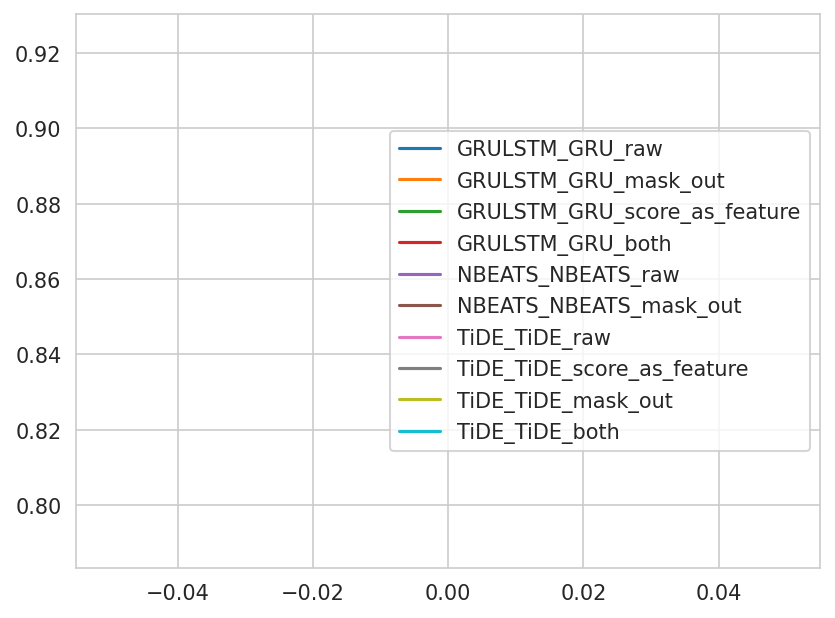

In [13]:
import pickle, gzip, matplotlib.pyplot as plt
with gzip.open("outputs/ch4/prev_results/settings_2/loss_histories.pkl.gz", "rb") as fh:
    curves = pickle.load(fh)

for k, v in curves.items():
    plt.plot(v, label=k)
plt.legend(); plt.show()

KeyError: 'XGBoost_XGB_raw'

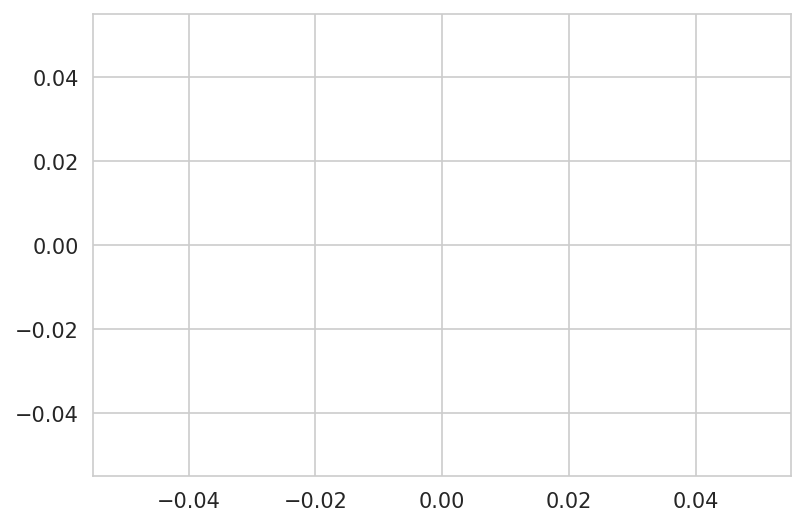

In [16]:
# ------------------ plotting cell / script ------------------
import pickle, gzip, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid")

# paths
LOSS_FILE   = "outputs/ch4/prev_results/settings_2/loss_histories.pkl.gz"
RESULTS_CSV = "outputs/ch4/all_model_results.csv"

# ---------- load ----------
with gzip.open(LOSS_FILE, "rb") as fh:
    curves = pickle.load(fh)         # dict[variant_key] -> list[float]
res = pd.read_csv(RESULTS_CSV)

# ---------- find best & worst (24 h MAE) ----------
h24 = res[res.horizon == 24].copy()
best_row  = h24.loc[h24.MAE.idxmin()]
worst_row = h24.loc[h24.MAE.idxmax()]
best_key  = f"{best_row.model}_{best_row.experiment}"
worst_key = f"{worst_row.model}_{worst_row.experiment}"

# ---------- Figure A: best vs worst ----------
plt.figure(figsize=(6,4))
for k, c in zip([best_key, worst_key], ["tab:green", "tab:red"]):
    plt.plot(curves[k], label=k, color=c, linewidth=2)
plt.xlabel("Epoch"); plt.ylabel("Training loss"); plt.title("Best vs Worst (24 h MAE)")
plt.legend(); plt.tight_layout()
plt.savefig("outputs/ch4/best_vs_worst_loss.png", dpi=300)
plt.show()

# ---------- Figure B: one curve per family ----------
families   = ["GRULSTM_GRU_raw", "NBEATS_NBEATS_raw", "TiDE_TiDE_raw",
              "PatchTST_PatchTST_raw", "XGBoost_XGB_raw", "SARIMA_SARIMA_raw"]
plt.figure(figsize=(7,4))
for fam in families:
    if fam in curves:
        plt.plot(curves[fam], label=fam)
plt.xlabel("Epoch"); plt.ylabel("Training loss"); plt.title("Representative training curves (Jacksonville)")
plt.legend(fontsize=8); plt.tight_layout()
plt.savefig("outputs/ch4/family_loss_curves.png", dpi=300)
plt.show()

In [17]:
for k, v in curves.items():
    print(k, len(v), v[:3])   # first few losses

GRULSTM_GRU_raw 9 [0.9236002308981759, 0.8726089171000889, 0.7612875870295933]
GRULSTM_GRU_mask_out 8 [0.7765542013304574, 0.7001588770321437, 0.5934027092797416]
GRULSTM_GRU_score_as_feature 12 [0.9292773604393005, 0.8488885845456805, 0.7293573192187718]
GRULSTM_GRU_both 11 [0.7897214378629412, 0.7352263501712254, 0.6591705083847046]
NBEATS_NBEATS_raw 0 []
NBEATS_NBEATS_mask_out 0 []
TiDE_TiDE_raw 0 []
TiDE_TiDE_score_as_feature 0 []
TiDE_TiDE_mask_out 0 []
TiDE_TiDE_both 0 []
